## Часть 1 - Статистические модели прогнозирования

In [31]:
from warnings import filterwarnings

In [32]:
filterwarnings("ignore")

### 1. Подгрузка данных

In [33]:
import pandas as pd
import numpy as np

#Подгрузка данных

data = pd.read_csv("data/ghana_gdp.csv", parse_dates=["year"], index_col=["year"])
data.head()

,GDP (current US$)
year,
1960-01-01,1.217087e+09
1961-01-01,0.000000e+00
1962-01-01,1.382353e+09
1963-01-01,1.540616e+09
1964-01-01,1.731092e+09


### 2. Построение графиков

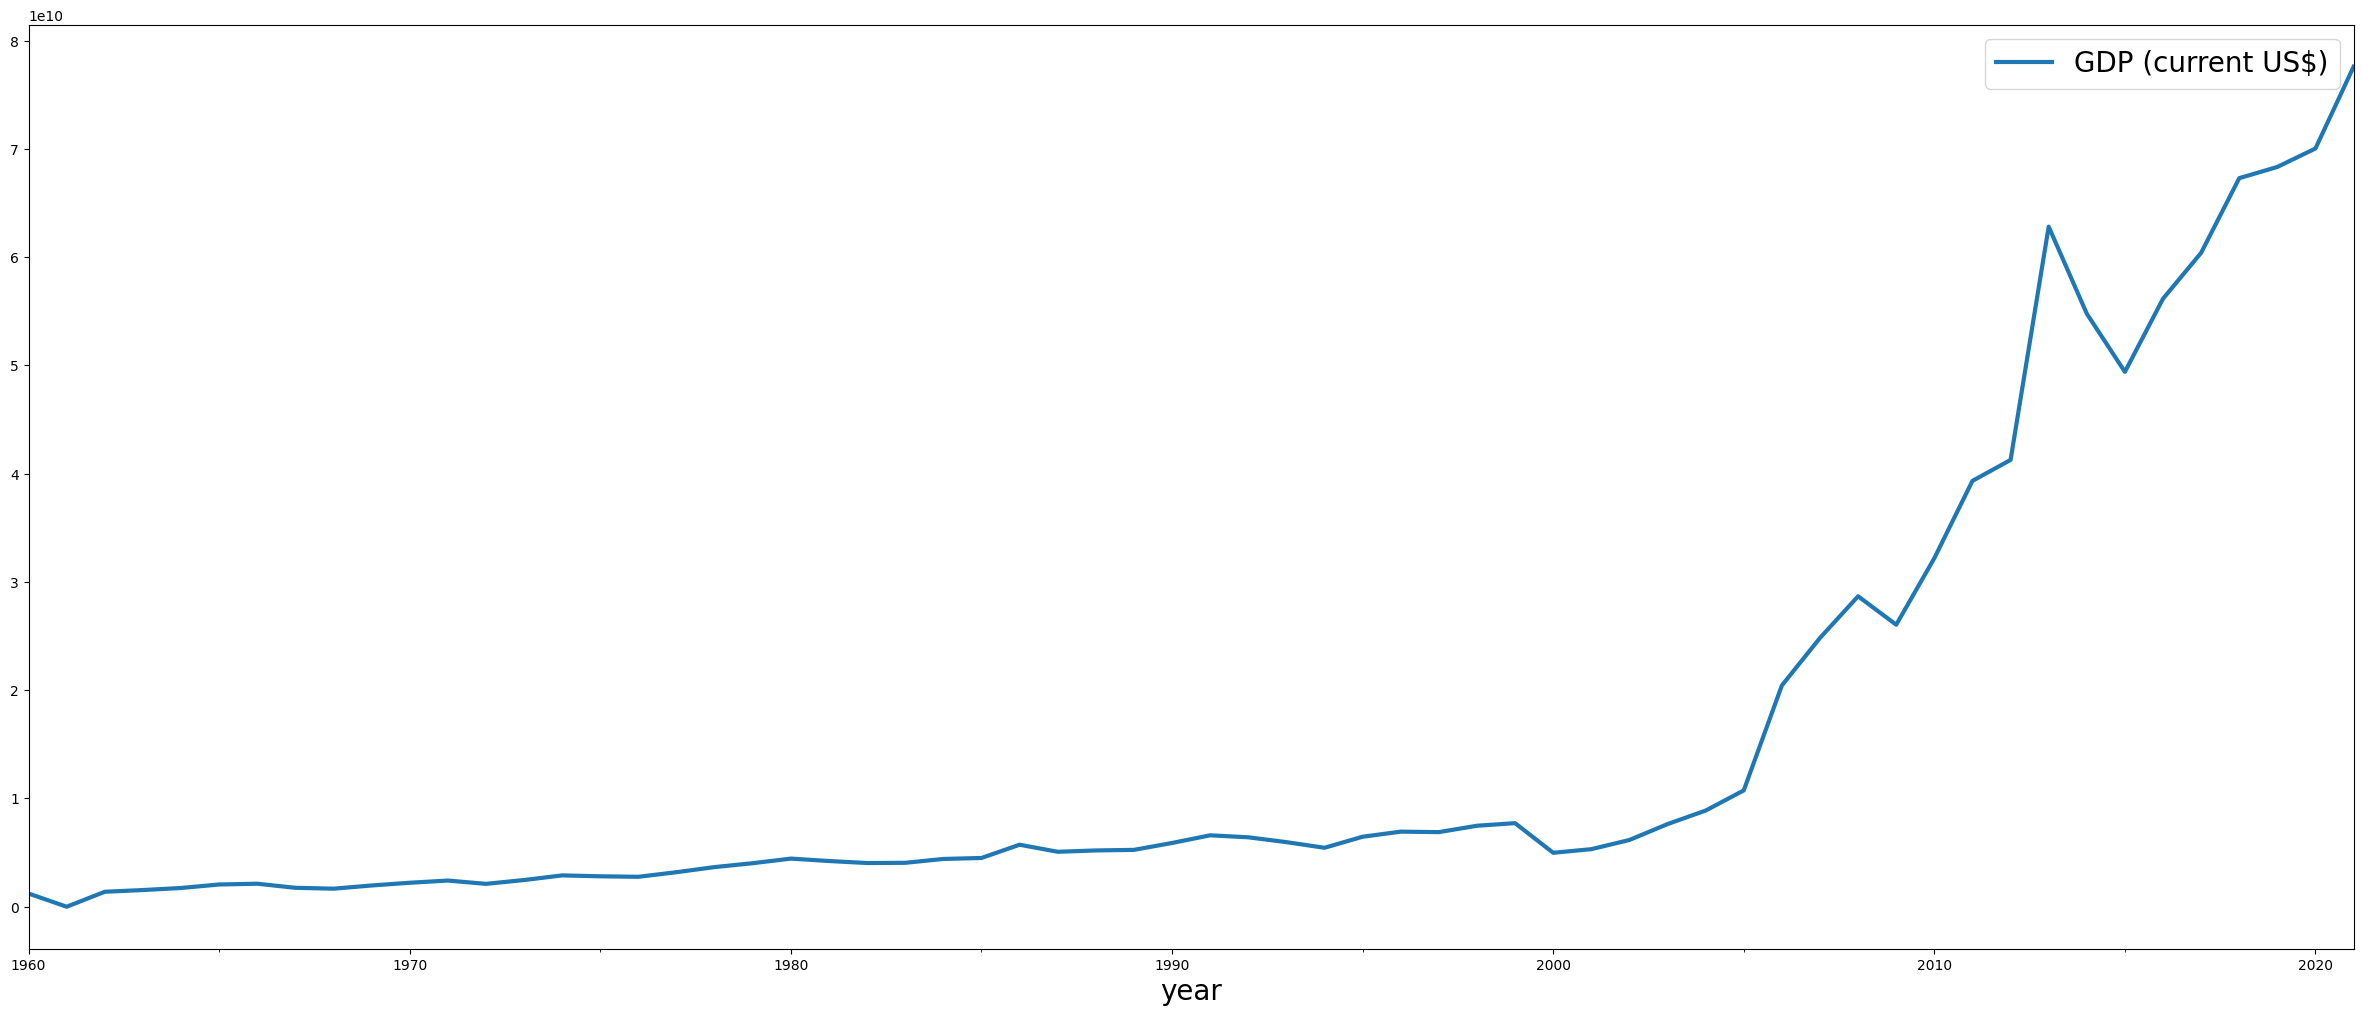

In [34]:
from matplotlib import pyplot as plt

%matplotlib inline

plt.rcParams["figure.figsize"] = 30, 12     # размер фигуры
plt.rcParams["font.size"] = 20              #  размер шрифта

# размер шрифта подписей делений (меток) по осям X и Y
plt.rcParams["xtick.labelsize"] = 10    
plt.rcParams["ytick.labelsize"] = 10

# толщина линии графика 
plt.rcParams["lines.linewidth"] = 3

data.plot()
plt.show()

### Вывод

> Наблюдается явнй тренд начиная с 2000-го года. На более старыхъ таймфреймах, также на блюдается плавный рост.

### 3. Скользящее стреднее. Тренд. Сезонность. Шум. Автокорреляция

In [35]:
train_df = data.loc[:"2018-12-31"]
test_df = data.loc["2019-01-01":]
train_df.shape, test_df.shape

((59, 1), (3, 1))

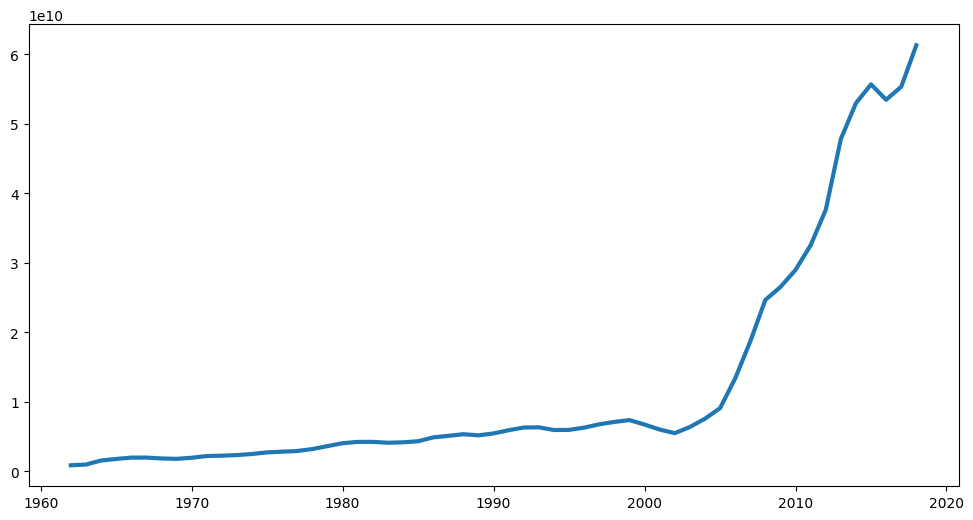

In [36]:
plt.figure(figsize=(12, 6))
plt.plot(train_df['GDP (current US$)'].rolling(window=3).mean())

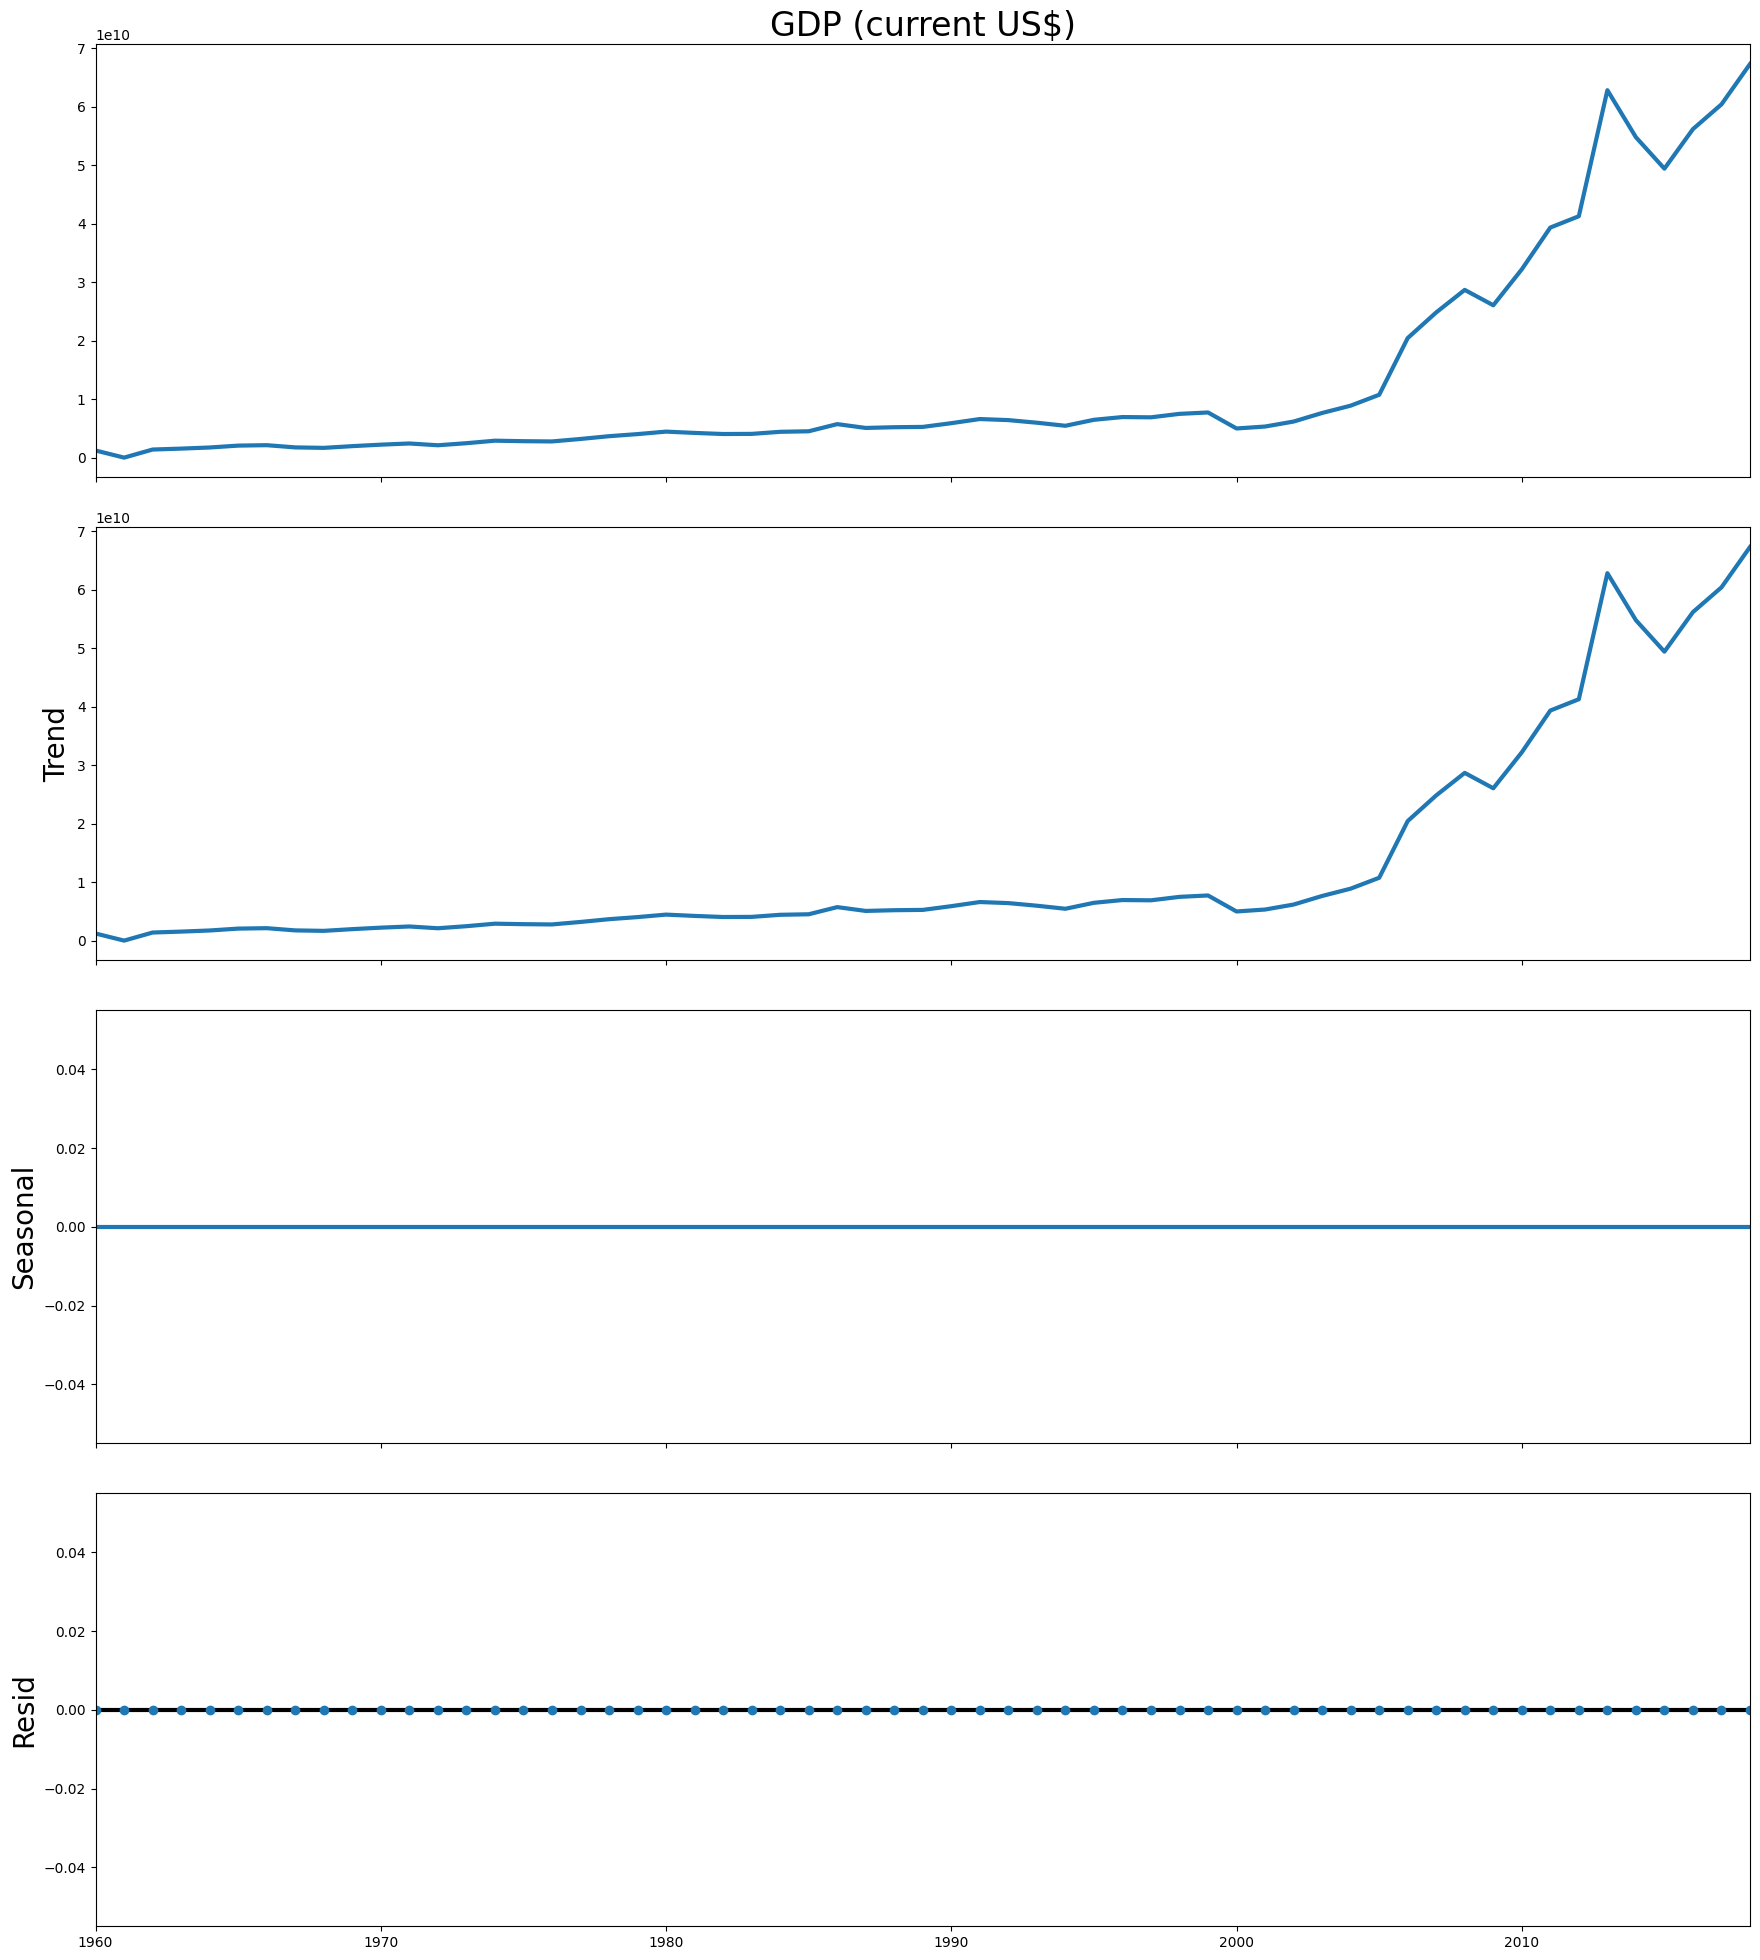

In [37]:
from statsmodels.tsa.seasonal import seasonal_decompose

plt.rcParams["figure.figsize"] = 18, 20

result = seasonal_decompose(train_df['GDP (current US$)'])
result.plot()
plt.show()

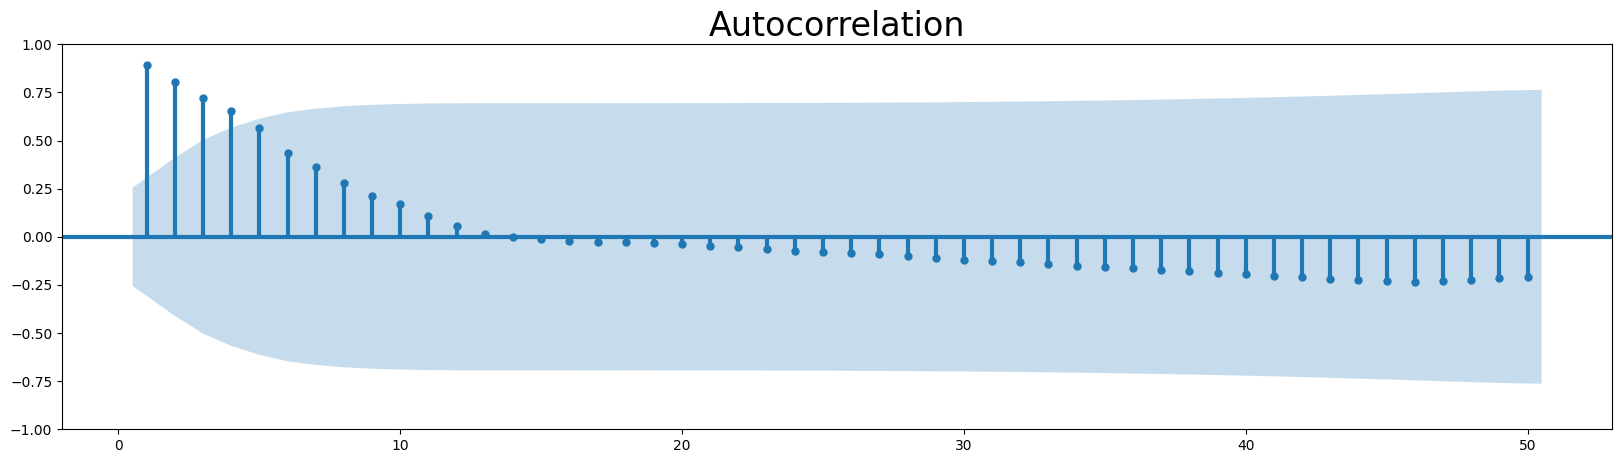

In [38]:
import statsmodels.graphics.tsaplots as sgt

plt.rcParams["figure.figsize"] = 20, 5
sgt.plot_acf(train_df['GDP (current US$)'], lags=50, zero=False)
plt.show()

### Вывод

> Как показывал предыдущий график [2]. Наблюдается явный тренд.

> Сезонности не наблюдается

> Так как надасет не большой, шумов также не наблюдается.

> Автокорреляция до 10 лага

### 4. Тест на стационарность. Дифференцирование

In [39]:
import statsmodels.api as sm

def stat_test(df):
    test = sm.tsa.adfuller(df)
    print ('adf: ', test[0] )
    print ('p-value: ', test[1])
    print('Critical values: ', test[4])
    if test[0]> test[4]['5%']: 
        print ('ряд не стационарен')
    else:
        print ('ряд стационарен')

stat_test(train_df['GDP (current US$)'])


adf:  0.6529066974885349
p-value:  0.9888496277665572
Critical values:  {'1%': -3.5745892596209488, '5%': -2.9239543084490744, '10%': -2.6000391840277777}
ряд не стационарен


In [40]:
print('Period = 1:')
stat_test(train_df['GDP (current US$)'].diff(periods=1).dropna())
print('-------------------\nPeriod = 2:')
stat_test(train_df['GDP (current US$)'].diff(periods=2).dropna())

Period = 1:
adf:  -1.6702483038320777
p-value:  0.446502932971389
Critical values:  {'1%': -3.568485864, '5%': -2.92135992, '10%': -2.5986616}
ряд не стационарен
-------------------
Period = 2:
adf:  -3.5836708658260297
p-value:  0.006080989753876957
Critical values:  {'1%': -3.584828853223594, '5%': -2.9282991495198907, '10%': -2.6023438271604937}
ряд стационарен


In [41]:
import statsmodels.graphics.tsaplots as sgt

In [42]:
def plot_acf_pacf(series):
    plt.rcParams["figure.figsize"] = 18, 5

    fig, axes = plt.subplots(1, 2)

    sgt.plot_acf(series, ax=axes[0], lags=10)
    sgt.plot_pacf(series, ax=axes[1], lags=10, method="ywm")
    plt.show()

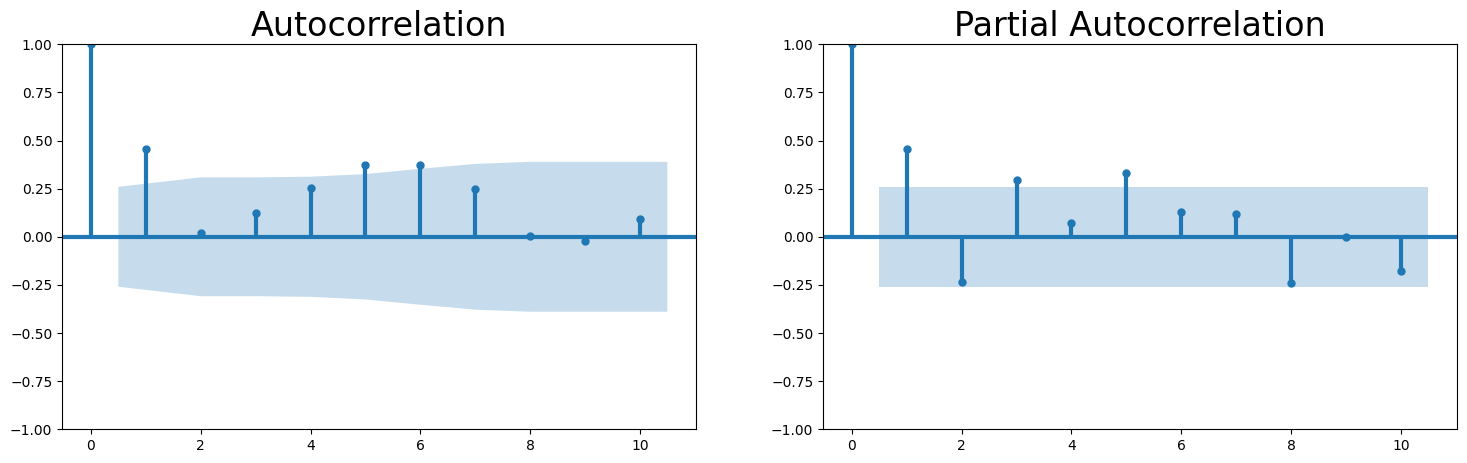

In [43]:
plot_acf_pacf(train_df['GDP (current US$)'].diff(periods=2).dropna())

### Вывод

> Тест  Дики-Фуллера показал, что ряд не старционарен.

> Ряд становится стационарным при применение цифференцирования 2-го порядка (d == 2).

> По частичной автокорреляции дифф. ряда принимаем p и q == 2

### 5. Прогнозирвоание

In [44]:
# ARIMA (p = 2, d = 2, q = 2)

from statsmodels.tsa.arima.model import ARIMA

arima_model = ARIMA(train_df['GDP (current US$)'].dropna(), order=(2, 2, 2)) # p, d, q
arima_model_fit = arima_model.fit()
arima_model_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:      GDP (current US$)   No. Observations:                   59
Model:                 ARIMA(2, 2, 2)   Log Likelihood               -1332.986
Date:                Tue, 08 Jul 2025   AIC                           2675.972
Time:                        18:58:03   BIC                           2686.187
Sample:                    01-01-1960   HQIC                          2679.942
                         - 01-01-2018                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -1.0516      0.067    -15.748      0.000      -1.182      -0.921
ar.L2         -0.3640      0.091     -4.016      0.000      -0.542      -0.186
ma.L1          0.1476      0.112      1.318      0.188      -0.072       0.367
ma.L2         -0.8519      0.123     -6.941      0.000      -1.092      -0.611
sigma2       1.12e+19   1.85e-20   6.05e+38      0.000    1.12e+19    1.12e+19
===================================================================================
Ljung-Box (L1) (Q):                   0.02   Jarque-Bera (JB):               144.07
Prob(Q):                              0.90   Prob(JB):                         0.00
Heteroskedasticity (H):             149.95   Skew:                             1.16
Prob(H) (two-sided):                  0.00   Kurtosis:                        10.44
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 2.52e+54. Standard errors may be unstable.
"""

In [45]:
# ARIMA (p = 1, d = 1, q = 1)

arima_model2 = ARIMA(train_df['GDP (current US$)'].dropna(), order=(1, 1, 1))
arima_model2_fit = arima_model.fit()
arima_model2_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:      GDP (current US$)   No. Observations:                   59
Model:                 ARIMA(2, 2, 2)   Log Likelihood               -1332.986
Date:                Tue, 08 Jul 2025   AIC                           2675.972
Time:                        18:58:12   BIC                           2686.187
Sample:                    01-01-1960   HQIC                          2679.942
                         - 01-01-2018                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -1.0516      0.067    -15.748      0.000      -1.182      -0.921
ar.L2         -0.3640      0.091     -4.016      0.000      -0.542      -0.186
ma.L1          0.1476      0.112      1.318      0.188      -0.072       0.367
ma.L2         -0.8519      0.123     -6.941      0.000      -1.092      -0.611
sigma2       1.12e+19   1.85e-20   6.05e+38      0.000    1.12e+19    1.12e+19
===================================================================================
Ljung-Box (L1) (Q):                   0.02   Jarque-Bera (JB):               144.07
Prob(Q):                              0.90   Prob(JB):                         0.00
Heteroskedasticity (H):             149.95   Skew:                             1.16
Prob(H) (two-sided):                  0.00   Kurtosis:                        10.44
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 2.52e+54. Standard errors may be unstable.
"""

In [46]:
# SARIMAX

from statsmodels.tsa.statespace.sarimax import SARIMAX

seas_model = SARIMAX(
    train_df['GDP (current US$)'].dropna(), order=(2, 2, 2), seasonal_order=(0, 0, 0, 0) # Берём модель без учёта сезонности
)

seas_model_fit = seas_model.fit()
seas_model_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:      GDP (current US$)   No. Observations:                   59
Model:               SARIMAX(2, 2, 2)   Log Likelihood               -1332.986
Date:                Tue, 08 Jul 2025   AIC                           2675.972
Time:                        18:58:14   BIC                           2686.187
Sample:                    01-01-1960   HQIC                          2679.942
                         - 01-01-2018                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -1.0516      0.067    -15.748      0.000      -1.182      -0.921
ar.L2         -0.3640      0.091     -4.016      0.000      -0.542      -0.186
ma.L1          0.1476      0.112      1.318      0.188      -0.072       0.367
ma.L2         -0.8519      0.123     -6.941      0.000      -1.092      -0.611
sigma2       1.12e+19   1.85e-20   6.05e+38      0.000    1.12e+19    1.12e+19
===================================================================================
Ljung-Box (L1) (Q):                   0.02   Jarque-Bera (JB):               144.07
Prob(Q):                              0.90   Prob(JB):                         0.00
Heteroskedasticity (H):             149.95   Skew:                             1.16
Prob(H) (two-sided):                  0.00   Kurtosis:                        10.44
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 2.52e+54. Standard errors may be unstable.
"""

In [47]:
pred_df = pd.DataFrame(index=data.index)

pred_df["model_preds"] = arima_model_fit.predict(
    start=test_df.index[0], end=test_df.index[-1]
)


pred_df['GDP (current US$)'] = data['GDP (current US$)']

forecast = seas_model_fit.get_forecast(len(test_df.index))
forecast_df = forecast.conf_int(alpha=0.05)  # Confidence level of 95%

pred_df.at[test_df.index, "model_preds_lower"] = forecast_df["lower GDP (current US$)"]
pred_df.at[test_df.index, "model_preds_upper"] = forecast_df["upper GDP (current US$)"]

In [48]:
pred_df.tail()

,model_preds,GDP (current US$),model_preds_lower,model_preds_upper
year,,,,
2017-01-01,NaN,6.040638e+10,NaN,NaN
2018-01-01,NaN,6.729928e+10,NaN,NaN
2019-01-01,6.751437e+10,6.833754e+10,6.090316e+10,7.412557e+10
2020-01-01,7.304424e+10,7.004320e+10,6.331089e+10,8.277759e+10
2021-01-01,7.541597e+10,7.759428e+10,6.392009e+10,8.691184e+10


In [49]:
import plotly.graph_objs as go
from plotly.subplots import make_subplots

fig = make_subplots(rows=1, cols=1)

fig.add_trace(go.Scatter(
    x=pred_df.index,
    y=pred_df["GDP (current US$)"],
    mode='lines',
    name='Actuals',
    line=dict(color='blue', width=2),
    opacity=0.4
))

fig.add_trace(go.Scatter(
    x=pred_df.loc[test_df.index].index,
    y=pred_df.loc[test_df.index]["model_preds"],
    mode='lines',
    name='Out of Sample Fit',
    line=dict(color='red', width=2)
))

fig.add_trace(go.Scatter(
    x=pred_df.loc[test_df.index].index,
    y=pred_df.loc[test_df.index]["model_preds_upper"],
    mode='lines',
    name='Upper Bound',
    line=dict(color='green', dash='dash'),
    opacity=0.5
))

fig.add_trace(go.Scatter(
    x=pred_df.loc[test_df.index].index,
    y=pred_df.loc[test_df.index]["model_preds_lower"],
    mode='lines',
    name='Lower Bound',
    line=dict(color='green', dash='dash'),
    opacity=0.5
))

fig.update_layout(
    title='Interactive Model Fit',
    yaxis_title='GDP (current US$)',
    xaxis_title='Year',
    hovermode='x unified'
)

fig.show()

In [50]:
import pmdarima as pm

smodel = pm.auto_arima(
    train_df,   
    start_p=1,          # граница нижняя для p (AR)
    d=2,                # порядок дифференцирования (указан явно)
    start_q=1,          # граница нижняя для q (Ma)
    max_p=4,
    max_q=4,
    seasonal= False,
    test="adf",
    error_action="ignore",
    trace=True,
)

smodel.summary()

Performing stepwise search to minimize aic
 ARIMA(1,2,1)(0,0,0)[0] intercept   : AIC=2687.339, Time=0.03 sec
 ARIMA(0,2,0)(0,0,0)[0] intercept   : AIC=2721.886, Time=0.01 sec
 ARIMA(1,2,0)(0,0,0)[0] intercept   : AIC=2706.594, Time=0.01 sec
 ARIMA(0,2,1)(0,0,0)[0] intercept   : AIC=2687.662, Time=0.01 sec
 ARIMA(0,2,0)(0,0,0)[0]             : AIC=2719.959, Time=0.01 sec
 ARIMA(2,2,1)(0,0,0)[0] intercept   : AIC=2686.054, Time=0.02 sec
 ARIMA(2,2,0)(0,0,0)[0] intercept   : AIC=2694.896, Time=0.01 sec
 ARIMA(3,2,1)(0,0,0)[0] intercept   : AIC=2687.799, Time=0.04 sec
 ARIMA(2,2,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.13 sec
 ARIMA(1,2,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.08 sec
 ARIMA(3,2,0)(0,0,0)[0] intercept   : AIC=2695.926, Time=0.02 sec
 ARIMA(3,2,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.09 sec
 ARIMA(2,2,1)(0,0,0)[0]             : AIC=2683.782, Time=0.03 sec
 ARIMA(1,2,1)(0,0,0)[0]             : AIC=2684.416, Time=0.02 sec
 ARIMA(2,2,0)(0,0,0)[0]             : AIC=2693.0

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                   59
Model:               SARIMAX(1, 2, 3)   Log Likelihood               -1335.382
Date:                Tue, 08 Jul 2025   AIC                           2680.765
Time:                        18:58:23   BIC                           2690.980
Sample:                    01-01-1960   HQIC                          2684.735
                         - 01-01-2018                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.5682      0.163     -3.487      0.000      -0.888      -0.249
ma.L1         -0.4241      0.235     -1.803      0.071      -0.885       0.037
ma.L2         -0.8256      0.169     -4.886      0.000      -1.157      -0.494
ma.L3          0.5193      0.137      3.790      0.000       0.251       0.788
sigma2      1.868e+19   8.55e-21   2.18e+39      0.000    1.87e+19    1.87e+19
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):               173.00
Prob(Q):                              0.98   Prob(JB):                         0.00
Heteroskedasticity (H):             141.34   Skew:                             1.18
Prob(H) (two-sided):                  0.00   Kurtosis:                        11.20
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 5.43e+55. Standard errors may be unstable.
"""

### Вывод:

> Наилучшая модель ARIMA и SARIMA (p = 2, d = 2, q = 2) показывает AIC	2675

> Выполнен проноз

> Построен график визуализации. результаты близки к реальным

> Метод подбора параметров из библиотеки pmdarima принимает лучшие паарметры: **(p = 1, q = 3)**

## Часть 2 - Интерполяция и сэмплирование

### 1. Поиск пропусков

In [51]:
# Проверка пропусков методом asfreq (начало года)
data.asfreq(freq='AS').isna().sum()

GDP (current US$)    0
dtype: int64

In [52]:
data.head()

,GDP (current US$)
year,
1960-01-01,1.217087e+09
1961-01-01,0.000000e+00
1962-01-01,1.382353e+09
1963-01-01,1.540616e+09
1964-01-01,1.731092e+09


> Визуально, можно заметить, что уже во второй строке мы имеем пропущенное значение заполненное нулями

### 2. Замена пропусков

In [53]:
# Выполним замену нулевых значений на np.nan

data['GDP (current US$)'] = data['GDP (current US$)'].apply(lambda x: np.nan if x==0 else x)

In [54]:
# Повротная проверка

data.asfreq(freq='AS').isna().sum()

GDP (current US$)    1
dtype: int64

> По итогу поулчаем одно пропущенное значение (2-я строка)

In [55]:
# Используем интерполяцию для заполнения пропусков

df_intr = pd.DataFrame(data['GDP (current US$)'].interpolate(method='linear'))

> При помощи линейной интерполяцииполучаем значение в строке 2 ***([1] == [0]+[2] = (1.217087+1.382353)/2 = 1.288720)***

### 3. Формирование выборки. Статистические тесты

In [56]:
train_df = pd.DataFrame(df_intr.loc[:"2018-12-31"])
test_df = pd.DataFrame(df_intr.loc["2019-01-01":])

In [57]:
train_df.head()

,GDP (current US$)
year,
1960-01-01,1.217087e+09
1961-01-01,1.299720e+09
1962-01-01,1.382353e+09
1963-01-01,1.540616e+09
1964-01-01,1.731092e+09


In [58]:
stat_test(train_df['GDP (current US$)'])

adf:  0.8030073326980129
p-value:  0.9916845572455877
Critical values:  {'1%': -3.5745892596209488, '5%': -2.9239543084490744, '10%': -2.6000391840277777}
ряд не стационарен


In [59]:
print('Period = 1:')
stat_test(train_df['GDP (current US$)'].diff(periods=1).dropna())
print('-------------------\nPeriod = 2:')
stat_test(train_df['GDP (current US$)'].diff(periods=2).dropna())

Period = 1:
adf:  -1.8255652246435998
p-value:  0.36784515276563423
Critical values:  {'1%': -3.568485864, '5%': -2.92135992, '10%': -2.5986616}
ряд не стационарен
-------------------
Period = 2:
adf:  -3.999803440949147
p-value:  0.0014115408436661371
Critical values:  {'1%': -3.584828853223594, '5%': -2.9282991495198907, '10%': -2.6023438271604937}
ряд стационарен


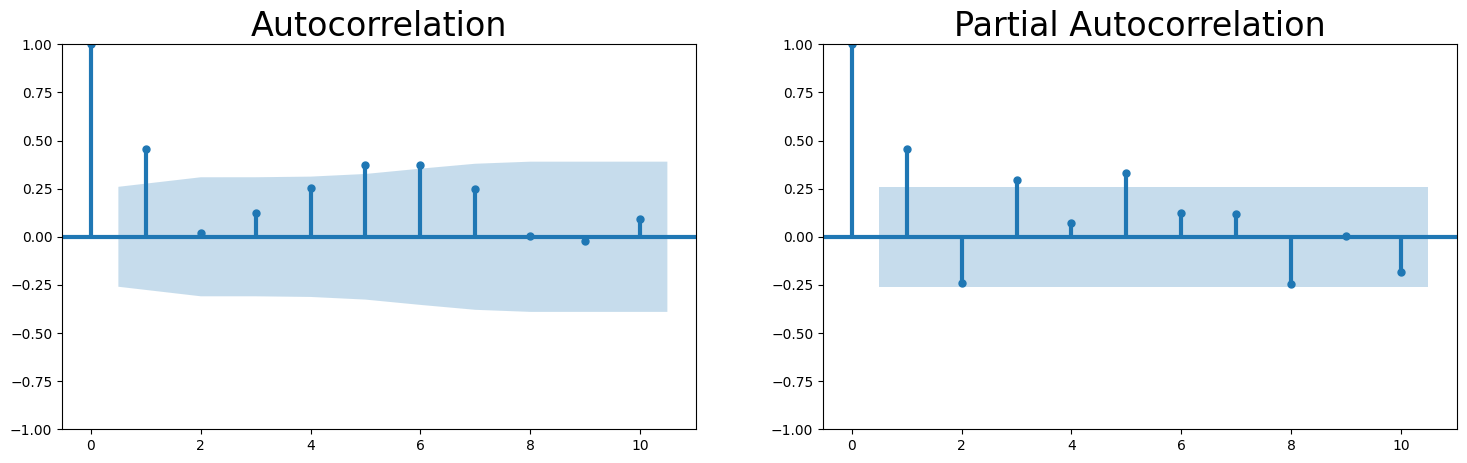

In [60]:
plot_acf_pacf(train_df['GDP (current US$)'].diff(periods=2).dropna())

### 4. Прогноз

In [61]:
arima_model = ARIMA(train_df.dropna(), order=(2, 2, 2)) # p, d, q
arima_model_fit = arima_model.fit()
arima_model_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:      GDP (current US$)   No. Observations:                   59
Model:                 ARIMA(2, 2, 2)   Log Likelihood               -1332.819
Date:                Tue, 08 Jul 2025   AIC                           2675.637
Time:                        18:58:44   BIC                           2685.853
Sample:                    01-01-1960   HQIC                          2679.607
                         - 01-01-2018                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -1.0456      0.068    -15.387      0.000      -1.179      -0.912
ar.L2         -0.3636      0.090     -4.047      0.000      -0.540      -0.188
ma.L1          0.1477      0.110      1.341      0.180      -0.068       0.364
ma.L2         -0.8515      0.122     -6.999      0.000      -1.090      -0.613
sigma2       1.12e+19   1.83e-20   6.11e+38      0.000    1.12e+19    1.12e+19
===================================================================================
Ljung-Box (L1) (Q):                   0.02   Jarque-Bera (JB):               151.26
Prob(Q):                              0.90   Prob(JB):                         0.00
Heteroskedasticity (H):             437.56   Skew:                             1.19
Prob(H) (two-sided):                  0.00   Kurtosis:                        10.62
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 6.32e+53. Standard errors may be unstable.
"""

In [62]:
pred_df = pd.DataFrame(index=data.index)

pred_df["model_preds"] = arima_model_fit.predict(
    start=test_df.index[0], end=test_df.index[-1]
)


pred_df['GDP (current US$)'] = df_intr['GDP (current US$)']

forecast = seas_model_fit.get_forecast(len(test_df.index))
forecast_df = forecast.conf_int(alpha=0.05)  # Confidence level of 95%

pred_df.at[test_df.index, "model_preds_lower"] = forecast_df["lower GDP (current US$)"]
pred_df.at[test_df.index, "model_preds_upper"] = forecast_df["upper GDP (current US$)"]

In [35]:
pred_df[-3:]

,model_preds,GDP (current US$),model_preds_lower,model_preds_upper
year,,,,
2019-01-01,6.741437e+10,6.833754e+10,6.090316e+10,7.412557e+10
2020-01-01,7.301723e+10,7.004320e+10,6.331089e+10,8.277759e+10
2021-01-01,7.534663e+10,7.759428e+10,6.392009e+10,8.691184e+10


### Вывод:

1. Было найдено одно пропущенной значение, которое заменено при моиощи линейной интерполяции

2. Выполнена повторная проверка ряда на стационарность - ***без изменений***

3. Выполнена повторная визуализация автокорелограмм - ***без изменений***

4. Выполнено повторное обучение ARIMA модели - ***AIC - без изменений***

> **Так как пропущенное значение всего одно, и находится в самом начале временного ряда (1961 г.). А предсказание мы строим на 2019-2021 гг. Данный пропуск не оказывает никакого влияния на обучение модели и технические характеристики временного ряда**

## Часть 3 - Модели прогнозирования гетероскедастичности. Валидация временных рядов.

### 1. Расчёт волатильности

In [75]:
# Для расчёта волатиьности примем датасет, где заменен пропуск с помощью интерполяции

df_intr["GDP_vol"] = df_intr['GDP (current US$)'].pct_change(1).mul(100).abs()
df_intr["GDP_vol"].head()

year
1960-01-01          NaN
1961-01-01     6.789413
1962-01-01     6.357759
1963-01-01    11.448835
1964-01-01    12.363636
Name: GDP_vol, dtype: float64

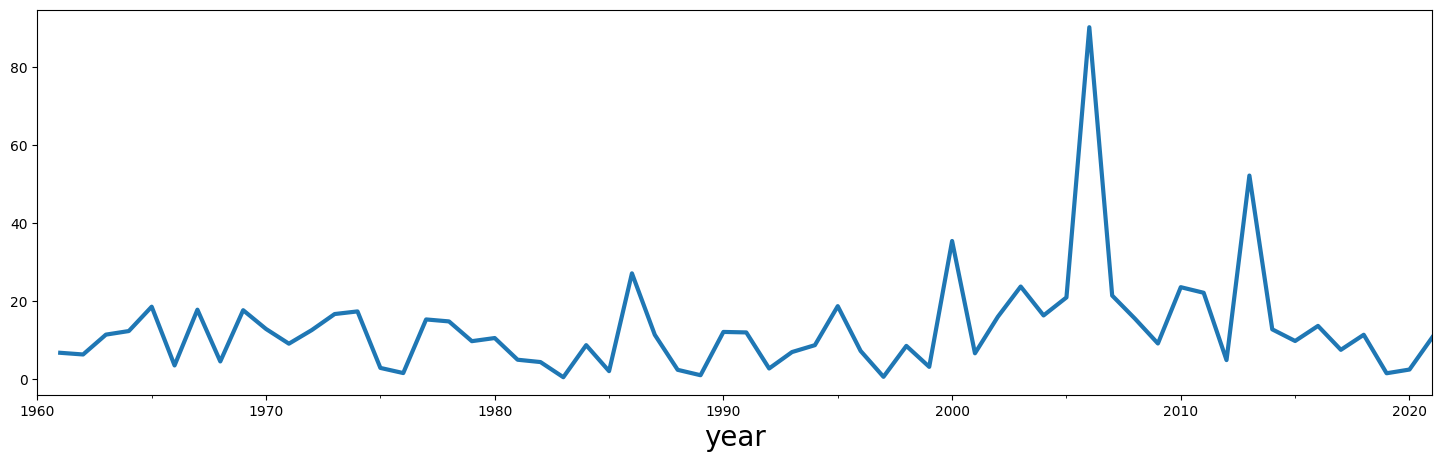

In [76]:
# Визуализация ряда волатильности

df_intr["GDP_vol"].plot()
plt.show()

> Визуально ряд статичный, с локальными всплесками в диапазоне 2000-2020

### 2. Проверка автокорреляции. Статистические тесты

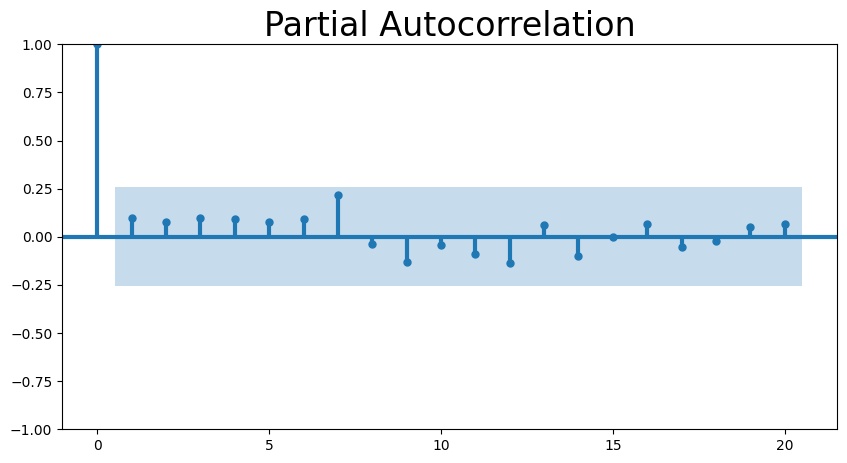

In [77]:
from matplotlib import pyplot as plt

train_df = df_intr.loc[:"2018-12-31"]
test_df = df_intr.loc["2019-01-01":]

plt.rcParams["figure.figsize"] = 10, 5

sgt.plot_pacf(train_df["GDP_vol"][1:], lags=20, method="ywm")
plt.show()

> Наиболее значимый лаг - 8. Но так как все показатели ниже 0.25, **значения p и q принимаем 1**

In [78]:
stat_test(train_df["GDP_vol"][1:])

adf:  -6.725311059553779
p-value:  3.4014596148856493e-09
Critical values:  {'1%': -3.5506699942762414, '5%': -2.913766394626147, '10%': -2.5946240473991997}
ряд стационарен


> Временной ряд стационарен - не требует дифференцирования.

In [67]:
# 1. Подготовка данных
garch_df = pd.DataFrame(df_intr["GDP_vol"].loc[df_intr.index])

# 2. Обучающая выборка
garch_df.loc[train_df.index, "GDP_vol"] = train_df["GDP_vol"].dropna()

In [68]:
from arch import arch_model

# 3. Модель
model = arch_model(garch_df["GDP_vol"].dropna(), p=1, q=1, vol = 'GARCH')


model_results = model.fit(last_obs=test_df.index[0], update_freq=5)


Iteration:      5,   Func. Count:     27,   Neg. LLF: 251.18811047858395
Iteration:     10,   Func. Count:     57,   Neg. LLF: 4522.5403032525255
Iteration:     15,   Func. Count:     89,   Neg. LLF: 228.00251345130135
Iteration:     20,   Func. Count:    114,   Neg. LLF: 226.5978293605918
Optimization terminated successfully    (Exit mode 0)
            Current function value: 226.59781233106128
            Iterations: 22
            Function evaluations: 123
            Gradient evaluations: 22


In [79]:
model_results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                     Constant Mean - GARCH Model Results                      
==============================================================================
Dep. Variable:                GDP_vol   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                      GARCH   Log-Likelihood:               -226.598
Distribution:                  Normal   AIC:                           461.196
Method:            Maximum Likelihood   BIC:                           469.437
                                        No. Observations:                   58
Date:                Tue, Jul 08 2025   Df Residuals:                       57
Time:                        19:11:09   Df Model:                            1
                               Mean Model                               
========================================================================
                 coef    std err          t      P>|t|  95.0% Conf. Int.
------------------------------------------------------------------------
mu            12.3191      2.572      4.790  1.666e-06 [  7.279, 17.360]
                            Volatility Model                            
========================================================================
                 coef    std err          t      P>|t|  95.0% Conf. Int.
------------------------------------------------------------------------
omega          3.6700     24.738      0.148      0.882 [-44.817, 52.157]
alpha[1]   6.0947e-11  9.201e-02  6.624e-10      1.000 [ -0.180,  0.180]
beta[1]        1.0000      0.157      6.384  1.725e-10 [  0.693,  1.307]
========================================================================

Covariance estimator: robust
"""

In [80]:
# 5. прогноз

predictions_df = test_df.copy()
predictions_df["Predictions"] = model_results.forecast().residual_variance.loc[
    test_df.index
]

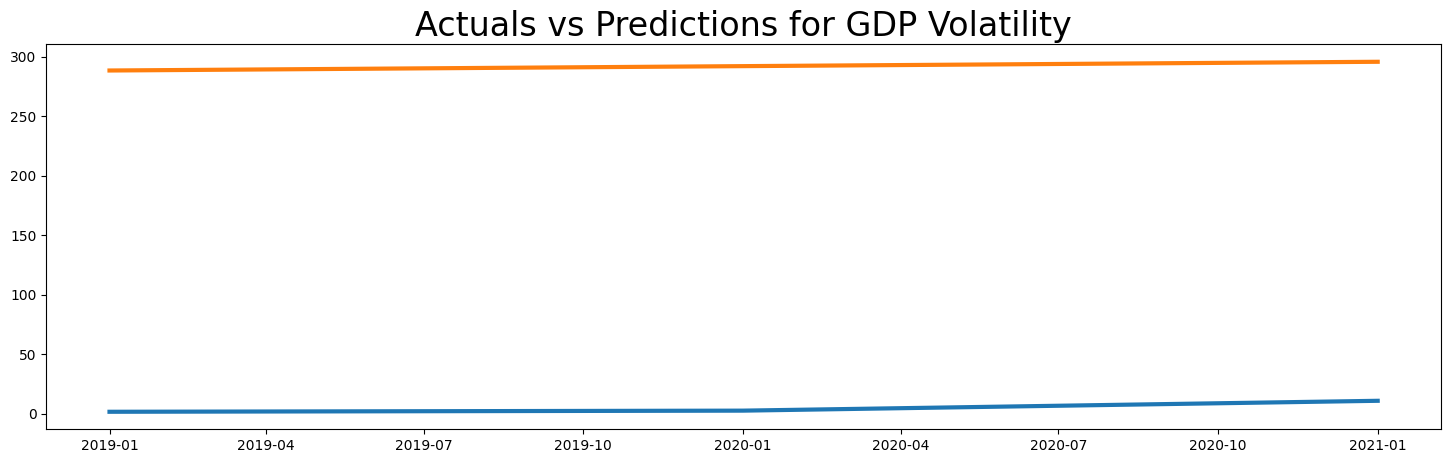

In [89]:
# 5. Визуализация

plt.rcParams["figure.figsize"] = 18, 5

plt.plot(predictions_df["GDP_vol"].abs())
plt.plot(predictions_df["Predictions"])

plt.title("Actuals vs Predictions for GDP Volatility", size=24)

plt.show()

> Судя по аизуализации графика, модель не уловала волатильность. скорее всего это связано с размром выборки, которая очень мала

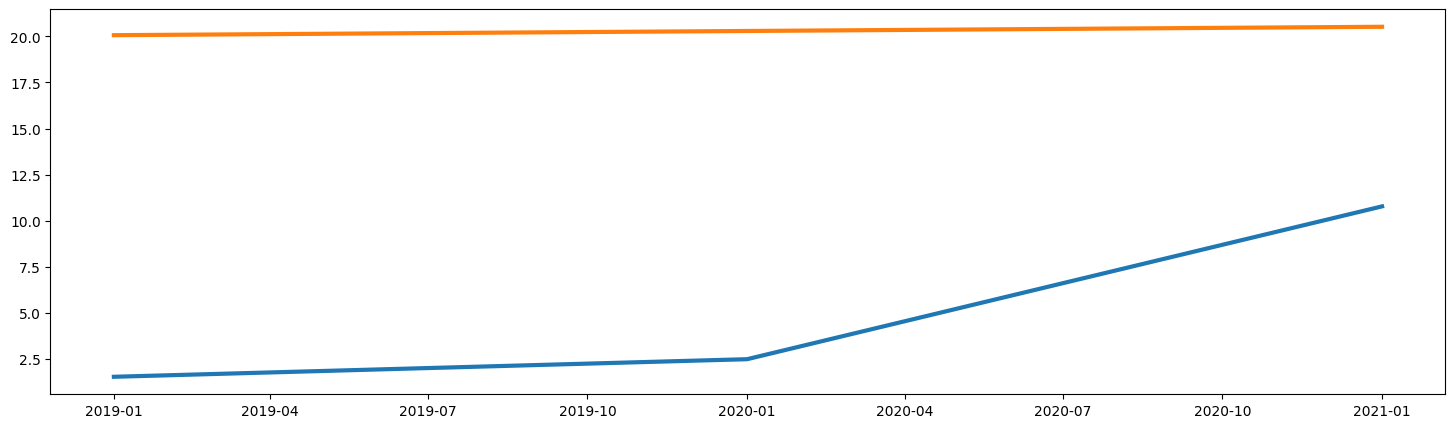

In [95]:
from sklearn.linear_model import LinearRegression

X_train = pd.DataFrame(range(df_intr["GDP_vol"].shape[0]))[
    : train_df.shape[0]
].fillna(0)
X_test = pd.DataFrame(range(df_intr["GDP_vol"].shape[0]))[
    train_df.shape[0] :
].fillna(0)
y_train = train_df["GDP_vol"].fillna(0)
y_test = test_df["GDP_vol"].fillna(0)


lr = LinearRegression()
lr.fit(X_train, y_train)
lr_predict = lr.predict(X_test)


plt.plot(y_test)
plt.plot(pd.Series(lr_predict, index=y_test.index))
plt.show()

> Модель линейной регресси также не справилась с предсказанием волатильности, так как кроме значений временного ряда у нас нет никаких данных, по итогу, вместо матрицы [X_train] мы поулчаем вектор из индексов, в связи с чем веса переменных (индексов) будут вычесленны некорректно.

### Вывод:

1. Рассчитана волатильность ВВП Ганы для временного ряда.

2. Построены графики визуализации

3. Из-за маленькой выборки GRACH не уловила закономерности. 

4. Модель линейной регрессии также не справилась с задачей. Для более корректной работы линейной регрессии необходимы фичи (несколько предыдущих значений и тп...) в качестве признаков